# Intrusion Detection System Demo
Build proposed architecture in [Network Intrusion Detection System using Deep Learning](https://www.sciencedirect.com/science/article/pii/S1877050921011078)

In [1]:
# Setup
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import  GridSearchCV

import tensorflow as tf
from keras import datasets, layers, models

# Import and explore data
We're going to be using the [UNSW-NB15 dataset](https://research.unsw.edu.au/projects/unsw-nb15-dataset). These papers elaborate its creation
- Moustafa, Nour, and Jill Slay. "UNSW-NB15: a comprehensive data set for network intrusion detection
systems (UNSW-NB15 network data set)."Military Communications and Information Systems Conference
(MilCIS), 2015. IEEE, 2015.
- Moustafa, Nour, and Jill Slay. "The evaluation of Network Anomaly Detection Systems: Statistical analysis
of the UNSW-NB15 data set and the comparison with the KDD99 data set." Information Security Journal:
A Global Perspective (2016): 1-14.

In [2]:
root = "./UNSW-NB15"

def read_UNSW_NB15(filename):
    return pd.read_csv(
        os.path.join(root, filename)
    )

Raw packet dumps. We're not going to use this for much, but it's useful to have around

In [ ]:
# nb15 = []

# for x in range(1, 5):
#     nb15.append(elal
#         read_UNSW_NB15(f"UNSW-NB15_{x}.csv")
#     )

# print(nb15)

FileNotFoundError: [Errno 2] No such file or directory: './UNSW-NB15/UNSW-NB15_1.csv'

Metadata files

In [ ]:
list_events = read_UNSW_NB15("UNSW-NB15_LIST_EVENTS.csv")
features = pd.read_csv(os.path.join(root, "NUSW-NB15_features.csv"), encoding='cp1252')

Finally, our training sets

In [ ]:
train = read_UNSW_NB15("UNSW_NB15_training-set.csv")
test = read_UNSW_NB15("UNSW_NB15_testing-set.csv")

Exploration based on [UNSW_NB15 notebook on kaggle](https://www.kaggle.com/code/melekbadreddine/unsw-nb15)

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
nb15[0].head()

,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0.17,3,7,1,3.1,1.1,1.2,1.3,Unnamed: 47,0.18
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0


In [ ]:
nb15[1].head()

,59.166.0.0,6055,149.171.126.5,54145,tcp,FIN,0.072974,4238,60788,31,...,0.6,13,13.1,6,7.1,1,1.1,2,Unnamed: 47,0.7
0,59.166.0.0,7832,149.171.126.3,5607,tcp,FIN,0.144951,5174,91072,31,...,0,13,13,6,7,1,1,2,NaN,0
1,59.166.0.8,11397,149.171.126.6,21,tcp,FIN,0.116107,2934,3742,31,...,1,1,2,7,5,1,1,4,NaN,0
2,59.166.0.0,3804,149.171.126.3,53,udp,CON,0.000986,146,178,31,...,0,13,13,6,7,1,1,2,NaN,0
3,59.166.0.8,14339,149.171.126.6,14724,tcp,FIN,0.038480,8928,320,31,...,0,8,20,7,5,1,1,4,NaN,0
4,59.166.0.8,39094,149.171.126.3,53,udp,CON,0.001026,130,162,31,...,0,8,13,6,5,1,1,1,NaN,0


In [ ]:
nb15[2].head()

,59.166.0.1,18247,149.171.126.4,7662,tcp,FIN,0.119596,4550,68342,31,...,,6,2,2.1,5,1,1.1,2.2,Unnamed: 47,0.4
0,59.166.0.3,54771,149.171.126.2,27709,tcp,FIN,0.650574,8928,320,31,...,,3,5,2,4,1,1,4,NaN,0
1,59.166.0.8,13289,149.171.126.9,5190,tcp,FIN,0.007980,2158,2464,31,...,,3,5,1,1,1,1,3,NaN,0
2,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,...,,19,19,19,19,19,19,19,NaN,0
3,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,...,,19,19,19,19,19,19,19,NaN,0
4,59.166.0.3,10275,149.171.126.0,25,tcp,FIN,0.486578,37462,3380,31,...,,3,2,3,4,2,1,2,NaN,0


In [ ]:
nb15[3].head()

,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,...,,2,2.1,7,4,1,1.1,3,Unnamed: 47,0.4
0,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,NaN,0
1,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,NaN,0
2,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,NaN,0
3,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,NaN,0
4,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,NaN,0


In [ ]:
list_events.head()

,Attack category,Attack subcategory,Number of events
0,normal,NaN,2218761
1,Fuzzers,FTP,558
2,Fuzzers,HTTP,1497
3,Fuzzers,RIP,3550
4,Fuzzers,SMB,5245


In [ ]:
features

,No.,Name,Type,Description
0,1,srcip,nominal,source IP address
1,2,sport,integer,source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,source to destination time to live value


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [ ]:
train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [ ]:
train.dtypes.value_counts()

int64      30
float64    11
object      4
Name: count, dtype: int64

Get non-numeric categories

In [ ]:
train.select_dtypes(exclude=np.number).columns

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

Binary columns

In [ ]:
train['is_sm_ips_ports'].value_counts()

is_sm_ips_ports
0    81416
1      916
Name: count, dtype: int64

In [ ]:
train['is_sm_ips_ports'].value_counts()

is_sm_ips_ports
0    81416
1      916
Name: count, dtype: int64

# Clean data
borrowed from [Hasherhri](https://github.com/Hashehri/Network-Traffic-Classification-UNSW-NB15/blob/main/code/Cleaning/data_cleaning.ipynb)

We need to replace `-` with `None` in the `service` column

In [ ]:
train['service'].value_counts()

service
-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: count, dtype: int64

In [ ]:
# removing all the "-" and replacing those with "None"
train['service'] = train['service'].apply(lambda x:"None" if x=="-" else x)

train['service'].value_counts()

service
None        47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: count, dtype: int64

# Exploratory Data Analysis

In [ ]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

Create correlation matrix visualization. Darker values are less correlated, brighter values are more correlated.

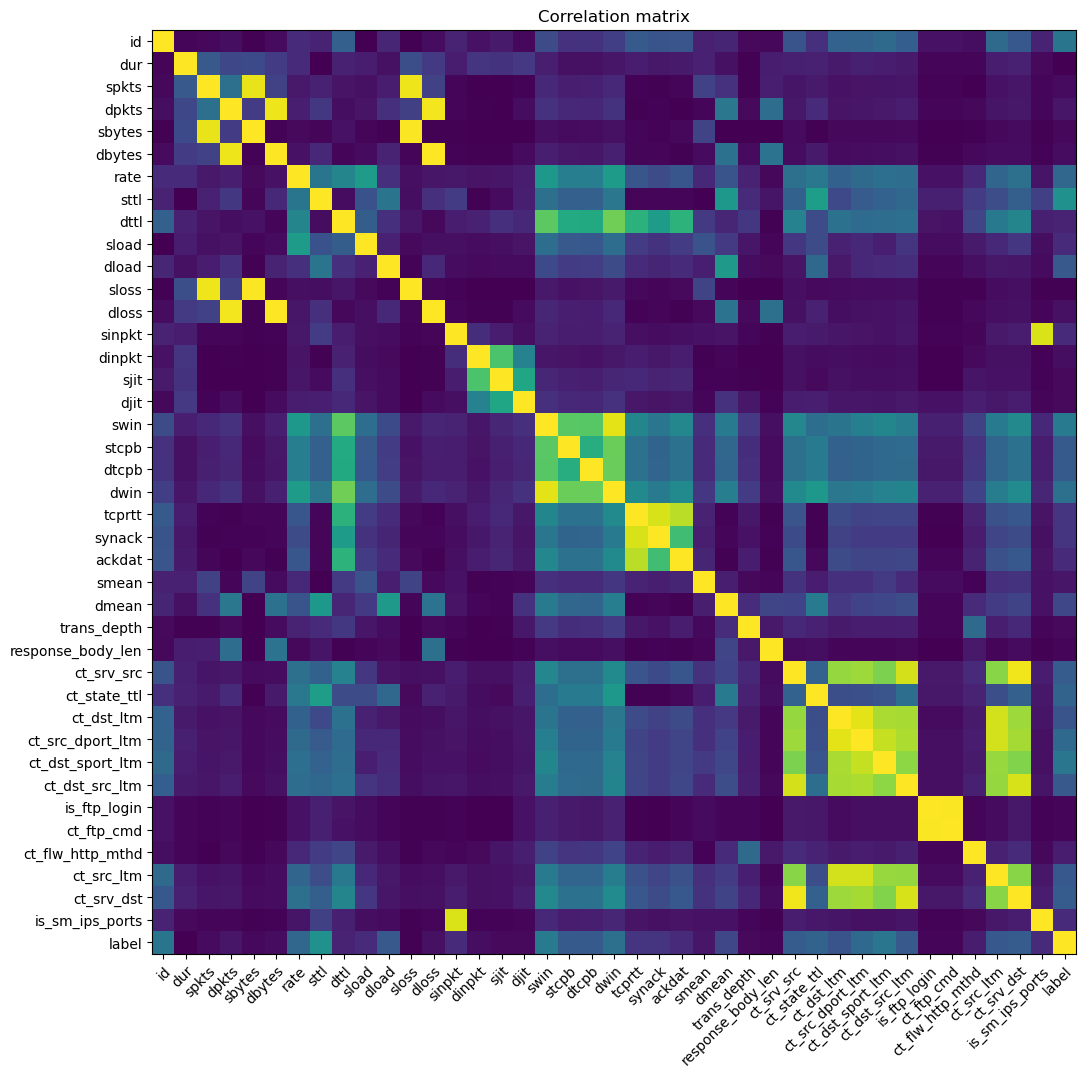

In [ ]:
correlation_matrix = train.select_dtypes(include=np.number).corr(method="pearson").abs()
labels = list(train.select_dtypes(include=np.number))

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(correlation_matrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation matrix")
plt.show()

Get highly correlated features

In [ ]:
limit = 0.9

columns = correlation_matrix.columns
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[0]):
        if abs(correlation_matrix.iloc[i, j]) >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {correlation_matrix.iloc[i, j]}")

spkts                sbytes               0.9657497410287414
spkts                sloss                0.9736439932787799
dpkts                dbytes               0.9764185516958216
dpkts                dloss                0.9815064328008422
sbytes               sloss                0.99502719113184
dbytes               dloss                0.9971088501020646
sinpkt               is_sm_ips_ports      0.9445057600994802
swin                 dwin                 0.9601246970559344
tcprtt               synack               0.9394732071062888
ct_srv_src           ct_dst_src_ltm       0.9337952137616565
ct_srv_src           ct_srv_dst           0.9778491535974652
ct_dst_ltm           ct_src_dport_ltm     0.9604008284955233
ct_dst_ltm           ct_src_ltm           0.9322524473427766
ct_src_dport_ltm     ct_dst_sport_ltm     0.9116374681078989
ct_src_dport_ltm     ct_src_ltm           0.9331720623302827
ct_dst_src_ltm       ct_srv_dst           0.9410468630509295
is_ftp_login         ct_ft

# Feature engineering

Get rid of unneeded feature

In [ ]:
train.drop('id', axis=1, inplace=True)

Remove highly correlated features

In [ ]:
# Selecting all the features with high correlation values with other features
corr_matrix = train.select_dtypes(include=np.number)\
    .corr(method="pearson").abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['sbytes',
 'dbytes',
 'sloss',
 'dloss',
 'dwin',
 'synack',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_ftp_cmd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']

We need two of these features for feature engineering

Create `network_bytes` as the the sum of `sbytes` and `dbytes`. It is the total number of bytes transferred by the network. We'll then drop `sbytes` and `dbytes`

In [ ]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [ ]:
train.drop(columns=to_drop, inplace=True)

Let's see the correlation matrix now!

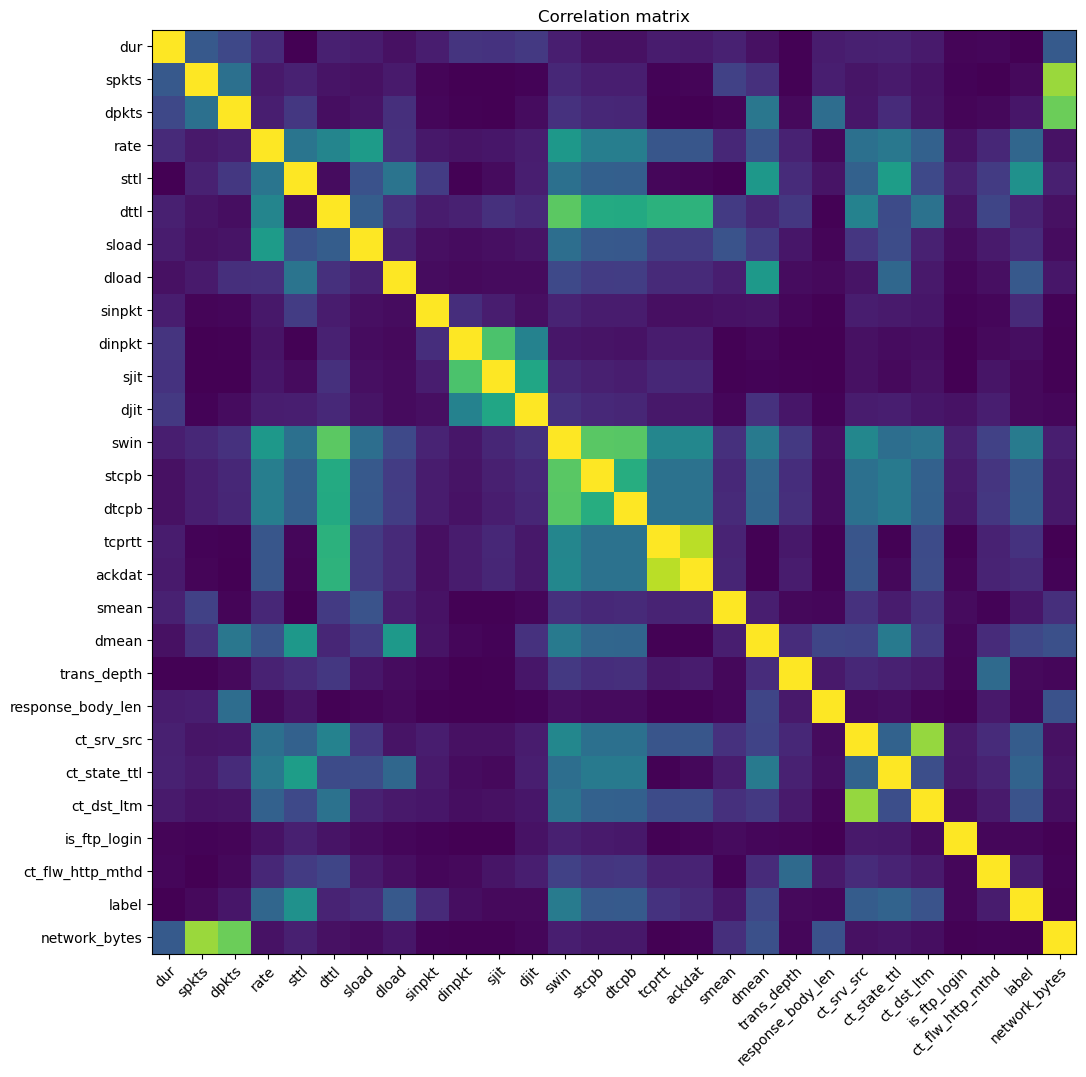

In [ ]:
correlation_matrix = train.select_dtypes(include=np.number).corr(method="pearson").abs()
labels = list(train.select_dtypes(include=np.number))

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(correlation_matrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Correlation matrix")
plt.show()

That looks like it has fewer correlations.

# Prepare data

We're going to use attack_cat as our target class

In [ ]:
print(train["attack_cat"].value_counts(normalize=True))
categories = list(train["attack_cat"].unique())

attack_cat
Normal            0.449400
Generic           0.229206
Exploits          0.135209
Fuzzers           0.073629
DoS               0.049665
Reconnaissance    0.042462
Analysis          0.008223
Backdoor          0.007081
Shellcode         0.004591
Worms             0.000534
Name: proportion, dtype: float64


9 of these categories are attacks, while one represents normal traffic.
Looks like normal traffic is only 31% of this dataset, followed by generic attacks.

In [ ]:
X_train = train.drop(columns=["attack_cat", "label"])
y_train = train["attack_cat"].copy()

X_test = test.drop(columns=["attack_cat", "label"])
y_test = test["attack_cat"].copy()

# Create Pipeline

Get attributes. See `features` for explainations of each attribute.

Note that `features` has some mislabeled and missing fields. I spent quite a lot of time debugging.

In [ ]:
feature_names = set(X_train)
for name in feature_names:
    print(name)

trans_depth
spkts
tcprtt
ct_dst_ltm
sttl
service
dmean
ct_srv_src
dpkts
dtcpb
ct_state_ttl
is_ftp_login
sinpkt
sjit
swin
network_bytes
sload
rate
proto
dttl
response_body_len
ct_flw_http_mthd
dload
state
smean
ackdat
stcpb
dur
djit
dinpkt


In [ ]:
cat_attribs = [
    "is_ftp_login",
    "proto",
    "state",
    "service",
    "swin",
    "dwin",
    "id",
    "proto"
]
print(cat_attribs)

['is_ftp_login', 'proto', 'state', 'service', 'swin', 'dwin', 'id', 'proto']


All other features are numeric

In [ ]:
num_attribs = list(feature_names.difference(set(cat_attribs)))

print(num_attribs)

['trans_depth', 'ct_dst_ltm', 'spkts', 'tcprtt', 'sttl', 'dmean', 'ct_srv_src', 'dpkts', 'dtcpb', 'ct_state_ttl', 'sinpkt', 'sjit', 'network_bytes', 'rate', 'sload', 'response_body_len', 'dttl', 'ct_flw_http_mthd', 'dload', 'smean', 'ackdat', 'stcpb', 'dur', 'djit', 'dinpkt']


Final double-check to make sure we got everything

In [ ]:
features_gotten = set(num_attribs).union(set(cat_attribs))
features_gotten == feature_names

False

In [ ]:

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("obj", OneHotEncoder(), cat_attribs),
])

X_train_normalized = full_pipeline.fit_transform(X_train)
X_train_normalized.shape

ValueError: A given column is not a column of the dataframe

# Reshape Data

In [ ]:
np.expand_dims(X_train_normalized, axis=1).shape  # Add a channel dimension

AxisError: axis 1 is out of bounds for array of dimension 1

AttributeError: 'csr_matrix' object has no attribute 'head'

# Create CNN

In [ ]:
list(train["stime"])

KeyError: 'stime'

In [ ]:
model = models.Sequential([
    layers.Input(shape=X_train_reshaped.shape), # TODO: Find shape
    layers.Conv1D(32, 6),
    layers.Conv1D(32, 6),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(32, 6),
    layers.Conv1D(32, 6),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(32, 6),
    layers.Conv1D(32, 6),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.4),
    layers.Conv1D(32, 6),
    layers.Dense(22),
    layers.MaxPooling1D(pool_size=2),
    layers.Dense(10, activation="softmax"), # output layer
])

ValueError: Input 0 of layer "conv1d_42" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 1)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])